<a href="https://colab.research.google.com/github/khakhiD/JavaScript/blob/master/car_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Colab과 Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Kaggle 데이터셋 저장을 위한 연결**

In [3]:
# Colab 환경에서 Kaggle을 사용하기 위한 설치 및 연결 과정
!pip install kaggle
from google.colab import files
 
files.upload()          # 본인 Kaggle Account API json 파일 업로드
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지용 코드
!chmod 600 ~/.kaggle/kaggle.json

# Kaggle 데이터셋 (car-object-detection) 다운로드
!kaggle datasets download -d sshikamaru/car-object-detection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json
 99% 111M/112M [00:00<00:00, 131MB/s] 
100% 112M/112M [00:00<00:00, 122MB/s]


In [4]:
# 다운로드한 데이터셋 압축 풀기
!unzip /content/car-object-detection.zip

Archive:  /content/car-object-detection.zip
  inflating: data/sample_submission.csv  
  inflating: data/testing_images/vid_5_25100.jpg  
  inflating: data/testing_images/vid_5_25120.jpg  
  inflating: data/testing_images/vid_5_25140.jpg  
  inflating: data/testing_images/vid_5_25160.jpg  
  inflating: data/testing_images/vid_5_25180.jpg  
  inflating: data/testing_images/vid_5_25200.jpg  
  inflating: data/testing_images/vid_5_25220.jpg  
  inflating: data/testing_images/vid_5_25240.jpg  
  inflating: data/testing_images/vid_5_25260.jpg  
  inflating: data/testing_images/vid_5_26320.jpg  
  inflating: data/testing_images/vid_5_26400.jpg  
  inflating: data/testing_images/vid_5_26420.jpg  
  inflating: data/testing_images/vid_5_26560.jpg  
  inflating: data/testing_images/vid_5_26580.jpg  
  inflating: data/testing_images/vid_5_26600.jpg  
  inflating: data/testing_images/vid_5_26620.jpg  
  inflating: data/testing_images/vid_5_26640.jpg  
  inflating: data/testing_images/vid_5_26660.jp

**1. 모듈 임포트**

In [5]:
# 필요 모듈 임포트
import os, time, random
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh
import matplotlib.pyplot as plt

# IPython에서 제공하는 Rich Output용 표현 방식
from IPython.display import Image, clear_output

# notebook 실행 브라우저에서 이미지 출력을 위한 코드
%matplotlib inline 

In [6]:
#시간 측정
%%time

# Yolov5 설치
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -U pycocotools
!pip install -qr yolov5/requirements.txt  # 의존성 설치
!cp yolov5/requirements.txt ./

Cloning into 'yolov5'...
remote: Enumerating objects: 12173, done.
remote: Total 12173 (delta 0), reused 0 (delta 0), pack-reused 12173
Receiving objects: 100% (12173/12173), 11.96 MiB | 33.93 MiB/s, done.
Resolving deltas: 100% (8428/8428), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 596 kB 8.1 MB/s 
CPU times: user 93.2 ms, sys: 44.9 ms, total: 138 ms
Wall time: 8.51 s


**2. 데이터 불러오기 / 전처리 과정**

In [7]:
# Path 변수 설정
bounding_box = '/content/data/train_solution_bounding_boxes (1).csv'
train_path = '/content/data/training_images/'
test_path = '/content/data/testing_images/'

In [8]:
# Convert를 위한 변수
height, width, num_channels = (380, 676, 3)

# 라벨링 데이터 불러오기
df = pd.read_csv(bounding_box)
df.rename(columns = {'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])

# 바운딩 박스 Yolo Style로 Convert하기 (이미지 크기에 대한 비율 값 형태)
df['x_center'] = (df['xmin'] + df['xmax']) / 2
df['y_center'] = (df['ymin'] + df['ymax']) / 2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center'] / width
df['w'] = df['w'] / width
df['y_center'] = df['y_center'] / height
df['h'] = df['h'] / height

df.head() # 확인용 출력

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0


In [9]:
# 이미지 shape 확인용 코드
index = list(set(df.image_id))
image = random.choice(index)
print("Image ID: %s"%(image))
img = cv2.imread(f'/content/data/training_images/{image}.jpg')
img.shape

Image ID: vid_4_29540


(380, 676, 3)

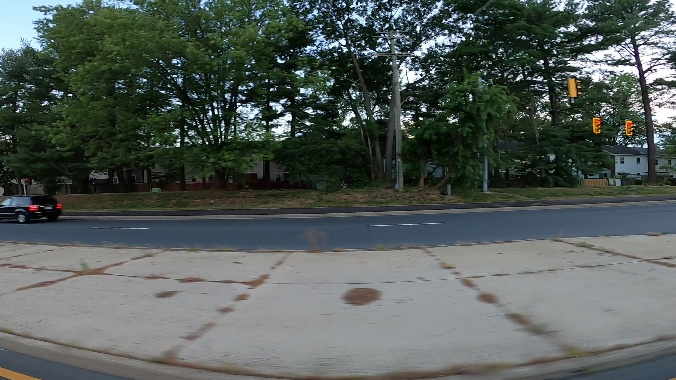

In [10]:
# 이미지 확인용 코드
image = random.choice(index)
Image(filename=f'{train_path}{image}.jpg', width=600)

**3. 학습 단계**

In [11]:
# 학습을 위한 디렉토리 정리
source = 'training_images'
if True:
    for fold in [0]:
        val_index = index[len(index) * fold // 5:len(index) * (fold + 1) // 5]

        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path_save = 'val2017/'
            else:
                path_save = 'train2017/'
            if not os.path.exists('/content/data/fold{}/labels/'.format(fold) + path_save):
                os.makedirs('/content/data/fold{}/labels/'.format(fold) + path_save)

            # 변환한 이미지 경로를 txt 파일로 저장한다.
            with open('/content/data/fold{}/labels/'.format(fold) + path_save + name + ".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")

            if not os.path.exists('/content/data/fold{}/images/{}'.format(fold, path_save)):
                os.makedirs('/content/data/fold{}/images/{}'.format(fold, path_save))

            sh.copy("/content/data/{}/{}.jpg".format(source,name),
                    '/content/data/fold{}/images/{}/{}.jpg'.format(fold, path_save, name))

  0%|          | 0/355 [00:00<?, ?it/s]

In [18]:
# YOLOv5s 모델을 활용하여 이미지 학습
!python /content/yolov5/train.py --img 676 --batch 16 --epochs 20 --data /content/yolov5/data.yaml --weights yolov5s.pt --name car-detection

train: weights=yolov5s.pt, cfg=, data=/content/yolov5/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=676, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=car-detection, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-244-g47233e1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamm

In [21]:
# 테스트
!python3 /content/yolov5/detect.py --source /content/data/testing_images --weights /content/yolov5/runs/train/car-detection/weights/best.pt

detect: weights=['/content/yolov5/runs/train/car-detection/weights/best.pt'], source=/content/data/testing_images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-244-g47233e1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/175 /content/data/testing_images/vid_5_25100.jpg: 384x640 Done. (0.011s)
image 2/175 /content/data/testing_images/vid_5_25120.jpg: 384x640 Done. (0.007s)
image 3/175 /content/data/testing_images/vid_5_25140.jpg: 384x640 Done. (0.007s)
image 4/175 /content/data/testing_images/vid_5_25160.jpg

In [22]:
# 예측된 이미지 파일들 리스트로 저장
predicted_files = []
for (dirpath, dirnames, filenames) in os.walk("/content/yolov5/runs/detect/exp2"):
    predicted_files.extend(filenames)

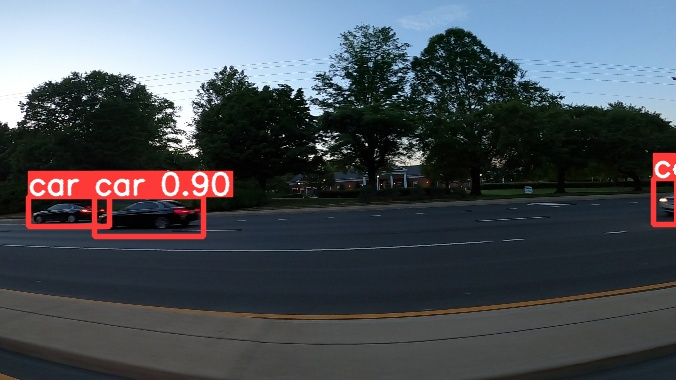

In [29]:
# 예측 이미지 확인하기 (랜덤)
Image(filename=f'/content/yolov5/runs/detect/exp2/{random.choice(predicted_files)}')

In [28]:
# 새로운 데이터 넣어 확인해보기
!python3 /content/yolov5/detect.py --source /content/data/test_set --weights /content/yolov5/runs/train/car-detection/weights/best.pt

detect: weights=['/content/yolov5/runs/train/car-detection/weights/best.pt'], source=/content/data/test_set, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-244-g47233e1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/5 /content/data/test_set/test1.jpg: 352x640 1 car, Done. (0.012s)
image 2/5 /content/data/test_set/test2.jpg: 640x576 1 car, Done. (0.012s)
image 3/5 /content/data/test_set/test3.jpg: 448x640 21 cars, Done. (0.011s)
image 4/5 /content/data/test_set/test4.jpg: 480x640 14 cars, Done. (0.011s)
image